<a href="https://colab.research.google.com/github/juniorskg/linear_regression/blob/main/dataintass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyspark


In [ ]:
import pyspark
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, when
from pyspark.sql.functions import col
from pyspark.sql.functions import count, col
from pyspark.sql.types import StringType
from pyspark.sql.functions import mean, avg
from pyspark.sql.functions import split, col
from pyspark.ml.feature import Imputer
from pyspark.ml.feature import StringIndexer
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import MinMaxScaler, VectorAssembler
from pyspark.ml.recommendation import ALS
import time
from pyspark.ml.evaluation import RegressionEvaluator

In [ ]:
spark=SparkSession.builder.appName("data_int").getOrCreate()
spark

In [ ]:
# File location and type
file_location = "/content/Users.csv"
file_type = "csv"

# CSV options
infer_schema = "false"
first_row_is_header = "true"

# The applied options are for CSV files. For other file types, these will be ignored.
user = spark.read.csv(file_location,header=True,inferSchema= True)




In [ ]:
user.show()

+-------+--------------------+----+
|User-ID|            Location| Age|
+-------+--------------------+----+
|      1|  nyc, new york, usa|NULL|
|      2|stockton, califor...|18.0|
|      3|moscow, yukon ter...|NULL|
|      4|porto, v.n.gaia, ...|17.0|
|      5|farnborough, hant...|NULL|
|      6|santa monica, cal...|61.0|
|      7| washington, dc, usa|NULL|
|      8|timmins, ontario,...|NULL|
|      9|germantown, tenne...|NULL|
|     10|albacete, wiscons...|26.0|
|     11|melbourne, victor...|14.0|
|     12|fort bragg, calif...|NULL|
|     13|barcelona, barcel...|26.0|
|     14|mediapolis, iowa,...|NULL|
|     15|calgary, alberta,...|NULL|
|     16|albuquerque, new ...|NULL|
|     17|chesapeake, virgi...|NULL|
|     18|rio de janeiro, r...|25.0|
|     19|           weston, ,|14.0|
|     20|langhorne, pennsy...|19.0|
+-------+--------------------+----+
only showing top 20 rows



In [ ]:
# File location and type
file_location = "/content/Ratings.csv"
file_type = "csv"

# CSV options
infer_schema = "false"
first_row_is_header = "true"

# The applied options are for CSV files. For other file types, these will be ignored.
rating = spark.read.csv(file_location,header=True,inferSchema= True)




In [ ]:
rating.show()

+-------+----------+-----------+
|User-ID|      ISBN|Book-Rating|
+-------+----------+-----------+
| 276725|034545104X|          0|
| 276726|0155061224|          5|
| 276727|0446520802|          0|
| 276729|052165615X|          3|
| 276729|0521795028|          6|
| 276733|2080674722|          0|
| 276736|3257224281|          8|
| 276737|0600570967|          6|
| 276744|038550120X|          7|
| 276745| 342310538|         10|
| 276746|0425115801|          0|
| 276746|0449006522|          0|
| 276746|0553561618|          0|
| 276746|055356451X|          0|
| 276746|0786013990|          0|
| 276746|0786014512|          0|
| 276747|0060517794|          9|
| 276747|0451192001|          0|
| 276747|0609801279|          0|
| 276747|0671537458|          9|
+-------+----------+-----------+
only showing top 20 rows



# **users data set**

In [ ]:
user.printSchema()

root
 |-- User-ID: integer (nullable = true)
 |-- Location: string (nullable = true)
 |-- Age: string (nullable = true)



# age

remove age less than 7 or more than 110 because there are invalind ages

In [ ]:
user = user.withColumn("Age", col("Age").cast("int"))

In [ ]:
user = user.withColumn("Age", when(col("Age") < 7 , None).otherwise(col("Age")))
user = user.withColumn("Age", when(col("Age") >111 , None).otherwise(col("Age")))

user.show()


+-------+--------------------+----+
|User-ID|            Location| Age|
+-------+--------------------+----+
|      1|  nyc, new york, usa|NULL|
|      2|stockton, califor...|  18|
|      3|moscow, yukon ter...|NULL|
|      4|porto, v.n.gaia, ...|  17|
|      5|farnborough, hant...|NULL|
|      6|santa monica, cal...|  61|
|      7| washington, dc, usa|NULL|
|      8|timmins, ontario,...|NULL|
|      9|germantown, tenne...|NULL|
|     10|albacete, wiscons...|  26|
|     11|melbourne, victor...|  14|
|     12|fort bragg, calif...|NULL|
|     13|barcelona, barcel...|  26|
|     14|mediapolis, iowa,...|NULL|
|     15|calgary, alberta,...|NULL|
|     16|albuquerque, new ...|NULL|
|     17|chesapeake, virgi...|NULL|
|     18|rio de janeiro, r...|  25|
|     19|           weston, ,|  14|
|     20|langhorne, pennsy...|  19|
+-------+--------------------+----+
only showing top 20 rows



count the number of null values in age

In [ ]:
null = user.select(count(when(col("Age").isNull(), "Age")).alias("null"))
null.show()

+------+
|  null|
+------+
|112205|
+------+



# User-ID

In [ ]:

null = user.select(count(when(col("User-ID").isNull(), "User-ID")).alias("null"))
null.show()

+----+
|null|
+----+
|   1|
+----+



In [ ]:
# Count occurrences of each name
counts = user.groupBy("User-ID").agg(count("*").alias("count"))

# Check if any name has more than one occurrence
duplicate_User_ID = counts.filter(col("count") > 1)

if duplicate_User_ID.count() == 0:
    print("All User-ID are unique.")
else:
    print("Duplicate User-ID found.")
    duplicate_User_ID.show()


All User-ID are unique.


# Location

In [ ]:


# Split the 'values' column into an array
user_location = user.withColumn('location_split', split(col('Location'), ','))

# Create separate columns for each element in the array
user = user_location.withColumn('city', col('location_split').getItem(0)) \
                   .withColumn('state', col('location_split').getItem(1)) \
                   .withColumn('country', col('location_split').getItem(2))

#Drop the temporary 'values_split' column
user = user.drop('location_split')
user= user.drop("country")
user= user.drop("state")
user=user.drop("location")

#print("DataFrame after splitting the 'values' column:")
#df_split.show()


In [ ]:
user.show()

+-------+----+--------------+
|User-ID| Age|          city|
+-------+----+--------------+
|      1|NULL|           nyc|
|      2|  18|      stockton|
|      3|NULL|        moscow|
|      4|  17|         porto|
|      5|NULL|   farnborough|
|      6|  61|  santa monica|
|      7|NULL|    washington|
|      8|NULL|       timmins|
|      9|NULL|    germantown|
|     10|  26|      albacete|
|     11|  14|     melbourne|
|     12|NULL|    fort bragg|
|     13|  26|     barcelona|
|     14|NULL|    mediapolis|
|     15|NULL|       calgary|
|     16|NULL|   albuquerque|
|     17|NULL|    chesapeake|
|     18|  25|rio de janeiro|
|     19|  14|        weston|
|     20|  19|     langhorne|
+-------+----+--------------+
only showing top 20 rows



In [ ]:
null = user.select(count(when(col("city").isNull(), "city")).alias("null"))
null.show()

+----+
|null|
+----+
|   0|
+----+



In [ ]:
user.printSchema()

root
 |-- User-ID: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- city: string (nullable = true)



# **rating dataset**

In [ ]:
rating.printSchema()

root
 |-- User-ID: integer (nullable = true)
 |-- ISBN: string (nullable = true)
 |-- Book-Rating: integer (nullable = true)



# book-rating

In [ ]:
rating = rating.withColumn("Book-Rating", when(col("Book-Rating") < 0 , None).otherwise(col("Book-Rating")))
rating = rating.withColumn("Book-Rating", when(col("Book-Rating") >10 , None).otherwise(col("Book-Rating")))

rating.show()

+-------+----------+-----------+
|User-ID|      ISBN|Book-Rating|
+-------+----------+-----------+
| 276725|034545104X|          0|
| 276726|0155061224|          5|
| 276727|0446520802|          0|
| 276729|052165615X|          3|
| 276729|0521795028|          6|
| 276733|2080674722|          0|
| 276736|3257224281|          8|
| 276737|0600570967|          6|
| 276744|038550120X|          7|
| 276745| 342310538|         10|
| 276746|0425115801|          0|
| 276746|0449006522|          0|
| 276746|0553561618|          0|
| 276746|055356451X|          0|
| 276746|0786013990|          0|
| 276746|0786014512|          0|
| 276747|0060517794|          9|
| 276747|0451192001|          0|
| 276747|0609801279|          0|
| 276747|0671537458|          9|
+-------+----------+-----------+
only showing top 20 rows



In [ ]:
null = rating.select(count(when(col("Book-Rating").isNull(), "Book-Rating")).alias("null"))
null.show()

+----+
|null|
+----+
|   0|
+----+



# user-id

In [ ]:
null = rating.select(count(when(col("User-ID").isNull(), "User-ID")).alias("null"))
null.show()

+----+
|null|
+----+
|   0|
+----+



# ISBN

In [ ]:
null = rating.select(count(when(col("ISBN").isNull(), "ISBN")).alias("null"))
null.show()

+----+
|null|
+----+
|   0|
+----+



# **MERGE BOTH DATASET**

In [ ]:
df = user.join(rating, 'User-ID', 'inner')

In [ ]:
df.show()

+-------+----+----------+----------+-----------+
|User-ID| Age|      city|      ISBN|Book-Rating|
+-------+----+----------+----------+-----------+
| 276725|NULL|     tyler|034545104X|          0|
| 276726|NULL|   seattle|0155061224|          5|
| 276727|  16|         h|0446520802|          0|
| 276729|  16|    rijeka|052165615X|          3|
| 276729|  16|    rijeka|0521795028|          6|
| 276733|  37|     paris|2080674722|          0|
| 276736|NULL|  salzburg|3257224281|          8|
| 276737|  14|    sydney|0600570967|          6|
| 276744|NULL|  torrance|038550120X|          7|
| 276745|  27|    berlin| 342310538|         10|
| 276746|NULL|fort worth|0425115801|          0|
| 276746|NULL|fort worth|0449006522|          0|
| 276746|NULL|fort worth|0553561618|          0|
| 276746|NULL|fort worth|055356451X|          0|
| 276746|NULL|fort worth|0786013990|          0|
| 276746|NULL|fort worth|0786014512|          0|
| 276747|  25| iowa city|0060517794|          9|
| 276747|  25| iowa 

fill age null value with median

In [ ]:
imputer= Imputer(
    inputCols=["Age"],
    outputCols=["{}_imputed".format(c)for c in ["Age"]]
).setStrategy("median")

In [ ]:
a=imputer.fit(df)
df=a.transform(df)

In [ ]:
df = df.drop('Age')


In [ ]:
df.show()

+-------+----------+----------+-----------+-----------+
|User-ID|      city|      ISBN|Book-Rating|Age_imputed|
+-------+----------+----------+-----------+-----------+
| 276725|     tyler|034545104X|          0|         35|
| 276726|   seattle|0155061224|          5|         35|
| 276727|         h|0446520802|          0|         16|
| 276729|    rijeka|052165615X|          3|         16|
| 276729|    rijeka|0521795028|          6|         16|
| 276733|     paris|2080674722|          0|         37|
| 276736|  salzburg|3257224281|          8|         35|
| 276737|    sydney|0600570967|          6|         14|
| 276744|  torrance|038550120X|          7|         35|
| 276745|    berlin| 342310538|         10|         27|
| 276746|fort worth|0425115801|          0|         35|
| 276746|fort worth|0449006522|          0|         35|
| 276746|fort worth|0553561618|          0|         35|
| 276746|fort worth|055356451X|          0|         35|
| 276746|fort worth|0786013990|          0|     

calculate the mode of country

In [ ]:
mode_country = df.groupBy("city").count().sort(col("count").desc()).first()["city"]


fill null value with mode

In [ ]:
null = user.select(count(when(col("city").isNull(), "city")).alias("null"))
null.show()

+----+
|null|
+----+
|   0|
+----+



In [ ]:
df = df.withColumn("city", when(df["city"].isNull(), mode_country).otherwise(df["city"]))

In [ ]:
df.show()

+-------+----------+----------+-----------+-----------+
|User-ID|      city|      ISBN|Book-Rating|Age_imputed|
+-------+----------+----------+-----------+-----------+
| 276725|     tyler|034545104X|          0|         35|
| 276726|   seattle|0155061224|          5|         35|
| 276727|         h|0446520802|          0|         16|
| 276729|    rijeka|052165615X|          3|         16|
| 276729|    rijeka|0521795028|          6|         16|
| 276733|     paris|2080674722|          0|         37|
| 276736|  salzburg|3257224281|          8|         35|
| 276737|    sydney|0600570967|          6|         14|
| 276744|  torrance|038550120X|          7|         35|
| 276745|    berlin| 342310538|         10|         27|
| 276746|fort worth|0425115801|          0|         35|
| 276746|fort worth|0449006522|          0|         35|
| 276746|fort worth|0553561618|          0|         35|
| 276746|fort worth|055356451X|          0|         35|
| 276746|fort worth|0786013990|          0|     

take london and barcelona data

In [ ]:
df=df.filter(col("city").isin(["london","barcelona"]))

take young adult of age 21-40

In [ ]:
df=df.filter(col("Age_imputed")>=21)
df=df.filter(col("Age_imputed")<=40)

remove 0 rating

In [ ]:
df=df.filter(col("Book-Rating")>0)

In [ ]:
df.show()

+-------+---------+----------+-----------+-----------+
|User-ID|     city|      ISBN|Book-Rating|Age_imputed|
+-------+---------+----------+-----------+-----------+
| 276925|barcelona|002542730X|         10|         22|
| 276925|barcelona|0099414732|          7|         22|
| 276925|barcelona|0140154078|          6|         22|
| 276925|barcelona|0194216748|          5|         22|
| 276925|barcelona|0385504209|          8|         22|
| 276925|barcelona|0553275283|          8|         22|
| 276925|barcelona|0582530431|          9|         22|
| 276925|barcelona|063403541X|          6|         22|
| 276925|barcelona|1400002672|          8|         22|
| 276925|barcelona|840149236X|          5|         22|
| 276925|barcelona|8420432113|          5|         22|
| 276925|barcelona|8420444367|          9|         22|
| 276925|barcelona|8422655500|          9|         22|
| 276925|barcelona|8422657104|          9|         22|
| 276925|barcelona|8423976645|          8|         22|
| 276925|b

convert string into numerical values

In [ ]:
indexer=StringIndexer(inputCols=["ISBN","city",],outputCols=["ISBN_indexed","city_indexed"])
df_ind=indexer.fit(df).transform(df)
df_ind.show()

+-------+---------+----------+-----------+-----------+------------+------------+
|User-ID|     city|      ISBN|Book-Rating|Age_imputed|ISBN_indexed|city_indexed|
+-------+---------+----------+-----------+-----------+------------+------------+
| 276925|barcelona|002542730X|         10|         22|       672.0|         1.0|
| 276925|barcelona|0099414732|          7|         22|        55.0|         1.0|
| 276925|barcelona|0140154078|          6|         22|       176.0|         1.0|
| 276925|barcelona|0194216748|          5|         22|      1525.0|         1.0|
| 276925|barcelona|0385504209|          8|         22|        78.0|         1.0|
| 276925|barcelona|0553275283|          8|         22|      2942.0|         1.0|
| 276925|barcelona|0582530431|          9|         22|      3127.0|         1.0|
| 276925|barcelona|063403541X|          6|         22|      3239.0|         1.0|
| 276925|barcelona|1400002672|          8|         22|      4312.0|         1.0|
| 276925|barcelona|840149236

In [ ]:
df_ind.columns

['User-ID',
 'city',
 'ISBN',
 'Book-Rating',
 'Age_imputed',
 'ISBN_indexed',
 'city_indexed']

In [ ]:
featurassembler=VectorAssembler(inputCols=["User-ID","Age_imputed","city_indexed","ISBN_indexed"], outputCol="Independent Features")
output= featurassembler.transform(df_ind)



In [ ]:
output.show()

+-------+---------+----------+-----------+-----------+------------+------------+--------------------+
|User-ID|     city|      ISBN|Book-Rating|Age_imputed|ISBN_indexed|city_indexed|Independent Features|
+-------+---------+----------+-----------+-----------+------------+------------+--------------------+
| 276925|barcelona|002542730X|         10|         22|       672.0|         1.0|[276925.0,22.0,1....|
| 276925|barcelona|0099414732|          7|         22|        55.0|         1.0|[276925.0,22.0,1....|
| 276925|barcelona|0140154078|          6|         22|       176.0|         1.0|[276925.0,22.0,1....|
| 276925|barcelona|0194216748|          5|         22|      1525.0|         1.0|[276925.0,22.0,1....|
| 276925|barcelona|0385504209|          8|         22|        78.0|         1.0|[276925.0,22.0,1....|
| 276925|barcelona|0553275283|          8|         22|      2942.0|         1.0|[276925.0,22.0,1....|
| 276925|barcelona|0582530431|          9|         22|      3127.0|         1.0|[2

In [ ]:
output.select("Independent Features").show()

+--------------------+
|Independent Features|
+--------------------+
|[276925.0,22.0,1....|
|[276925.0,22.0,1....|
|[276925.0,22.0,1....|
|[276925.0,22.0,1....|
|[276925.0,22.0,1....|
|[276925.0,22.0,1....|
|[276925.0,22.0,1....|
|[276925.0,22.0,1....|
|[276925.0,22.0,1....|
|[276925.0,22.0,1....|
|[276925.0,22.0,1....|
|[276925.0,22.0,1....|
|[276925.0,22.0,1....|
|[276925.0,22.0,1....|
|[276925.0,22.0,1....|
|[276925.0,22.0,1....|
|[276925.0,22.0,1....|
|[276925.0,22.0,1....|
|[277072.0,35.0,0....|
|[277087.0,29.0,1....|
+--------------------+
only showing top 20 rows



In [ ]:
finalized_data=output.select("Independent Features","Book-Rating")

In [ ]:
finalized_data.show()

+--------------------+-----------+
|Independent Features|Book-Rating|
+--------------------+-----------+
|[276925.0,22.0,1....|         10|
|[276925.0,22.0,1....|          7|
|[276925.0,22.0,1....|          6|
|[276925.0,22.0,1....|          5|
|[276925.0,22.0,1....|          8|
|[276925.0,22.0,1....|          8|
|[276925.0,22.0,1....|          9|
|[276925.0,22.0,1....|          6|
|[276925.0,22.0,1....|          8|
|[276925.0,22.0,1....|          5|
|[276925.0,22.0,1....|          5|
|[276925.0,22.0,1....|          9|
|[276925.0,22.0,1....|          9|
|[276925.0,22.0,1....|          9|
|[276925.0,22.0,1....|          8|
|[276925.0,22.0,1....|          8|
|[276925.0,22.0,1....|          4|
|[276925.0,22.0,1....|         10|
|[277072.0,35.0,0....|          9|
|[277087.0,29.0,1....|          8|
+--------------------+-----------+
only showing top 20 rows



 linear regression

In [ ]:

train_data,test_data=finalized_data.randomSplit([0.8,0.2])
regressor= LinearRegression(featuresCol="Independent Features",labelCol="Book-Rating")

regressor= regressor.fit(train_data)




In [ ]:
regressor.coefficients

DenseVector([-0.0, 0.0175, -0.1864, -0.0001])

In [ ]:
predictions=regressor.transform(test_data)

In [ ]:
pred_results= regressor.evaluate(test_data)

In [ ]:
pred_results.predictions.show()

+--------------------+-----------+------------------+
|Independent Features|Book-Rating|        prediction|
+--------------------+-----------+------------------+
|[102.0,35.0,1.0,5...|          7|7.1983888174770945|
|[2789.0,28.0,1.0,...|          8| 7.363074073245123|
|[2789.0,28.0,1.0,...|          5| 7.070923318463471|
|[2789.0,28.0,1.0,...|          5| 7.051062011861954|
|[3101.0,28.0,1.0,...|          5|7.0918579548166285|
|[3675.0,24.0,1.0,...|          6| 7.478350670109078|
|[3675.0,24.0,1.0,...|          7| 7.438051172481933|
|[3675.0,24.0,1.0,...|          5|  7.42338182569741|
|[3675.0,24.0,1.0,...|         10| 7.113842126131858|
|[3675.0,24.0,1.0,...|          6|  7.04263810578451|
|[3675.0,24.0,1.0,...|          7|6.9720933819218605|
|[4802.0,28.0,0.0,...|          7| 7.534925035719226|
|[4802.0,28.0,0.0,...|          6| 7.422844633320623|
|[4802.0,28.0,0.0,...|          9| 7.362271768789025|
|[5366.0,37.0,1.0,...|          7|   7.2211143300666|
|[8609.0,29.0,0.0,...|      

evaluate model with mean absolute error metric

In [ ]:
evaluator_mae = RegressionEvaluator(labelCol="Book-Rating", predictionCol='prediction', metricName='mae')
mae = evaluator_mae.evaluate(predictions)
print(f"Mean Absolute Error (MAE): {mae}")

Mean Absolute Error (MAE): 1.331519342928754


evaluate time spark take to execute 4 time linear regrssion

In [ ]:

train_data,test_data=finalized_data.randomSplit([0.8,0.2])
regressor= LinearRegression(featuresCol="Independent Features",labelCol="Book-Rating")
start_time=time.time()
regressor= [regressor.fit(train_data)for i in range (4)]
end_time=time.time()
regressor_time=end_time-start_time


try with scaled data to compare

In [ ]:
scaler = MinMaxScaler(inputCol="Independent Features", outputCol="scaled_Independent Features")

scaler_model = scaler.fit(output)
df_scaled = scaler_model.transform(output)

In [ ]:
finalized_data_scaled=df_scaled .select("scaled_Independent Features","Book-Rating")

In [ ]:
finalized_data_scaled.show()

+---------------------------+-----------+
|scaled_Independent Features|Book-Rating|
+---------------------------+-----------+
|       [0.99654765247568...|         10|
|       [0.99654765247568...|          7|
|       [0.99654765247568...|          6|
|       [0.99654765247568...|          5|
|       [0.99654765247568...|          8|
|       [0.99654765247568...|          8|
|       [0.99654765247568...|          9|
|       [0.99654765247568...|          6|
|       [0.99654765247568...|          8|
|       [0.99654765247568...|          5|
|       [0.99654765247568...|          5|
|       [0.99654765247568...|          9|
|       [0.99654765247568...|          9|
|       [0.99654765247568...|          9|
|       [0.99654765247568...|          8|
|       [0.99654765247568...|          8|
|       [0.99654765247568...|          4|
|       [0.99654765247568...|         10|
|       [0.99707684443196...|          9|
|       [0.99713084361117...|          8|
+---------------------------+-----

 linear regression function after scaling the data



In [ ]:
train_data,test_data=finalized_data_scaled.randomSplit([0.8,0.2])
regressor= LinearRegression(featuresCol="scaled_Independent Features",labelCol="Book-Rating")

regressor= regressor.fit(train_data)



In [ ]:
regressor.coefficients

DenseVector([-0.0539, 0.223, -0.1931, -0.5369])

In [ ]:
predictions=regressor.transform(test_data)

In [ ]:
pred_results= regressor.evaluate(test_data)

In [ ]:
pred_results.predictions.show()

+---------------------------+-----------+------------------+
|scaled_Independent Features|Book-Rating|        prediction|
+---------------------------+-----------+------------------+
|       [2.66395950781548...|          4| 7.422825849299679|
|       [0.00509392257237...|          4| 7.177106763619061|
|       [0.00819707540445...|          8|7.6298616552748495|
|       [0.00821867507613...|          6| 7.622983834771846|
|       [0.00864346861927...|          7| 7.821226536350143|
|       [0.00890626462477...|         10| 7.175406027190787|
|       [0.01079623589721...|          7| 7.146960093185848|
|       [0.01286260448841...|          9| 7.521098869677841|
|       [0.01286260448841...|          9| 7.512760923437416|
|       [0.01286260448841...|          5| 7.478635514597743|
|       [0.01286260448841...|          8|7.1471806619887195|
|       [0.01286260448841...|         10| 7.095089987538235|
|       [0.01286260448841...|          6| 7.087869498010445|
|       [0.0128626044884

In [ ]:
evaluator_mae = RegressionEvaluator(labelCol="Book-Rating", predictionCol='prediction', metricName='mae')
mae = evaluator_mae.evaluate(predictions)
print(f"Mean Absolute Error (MAE): {mae}")

Mean Absolute Error (MAE): 1.340861002739165


In [ ]:
train_data,test_data=finalized_data_scaled.randomSplit([0.8,0.2])
regressor= LinearRegression(featuresCol="scaled_Independent Features",labelCol="Book-Rating")
start_time=time.time()
regressor= [regressor.fit(train_data)for i in range(4)]
end_time=time.time()
scaled_regressor_time=end_time-start_time

In [ ]:
print(f"the duration of the linear regression on spark is : {regressor_time}")
print(f"the duration of the linear regression of the scaled data  on spark is : {scaled_regressor_time}")

the duration of the linear regression on spark is : 35.574729919433594
the duration of the linear regression of the scaled data  on spark is : 31.675817251205444


In [ ]:
spark_regressor_time=spark.sparkContext.broadcast(regressor_time)
spark_scaled_regressor_time=spark.sparkContext.broadcast(scaled_regressor_time)

In [ ]:
import pandas as pd
from operator import add
from functools import reduce
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from multiprocessing import Pool
from multiprocessing.pool import ThreadPool
from sklearn.metrics import mean_absolute_error
import imblearn.over_sampling
import sklearn.preprocessing

In [ ]:
def central_tendancy_calculator(a,column):
#replacing dollar sign and converting to float if necessary
  try:
    # Remove dollar signs and commas, then convert to float
    a[column] = a[column].str.replace(r'[$,]', '', regex=True).astype(float)
  except Exception as e:
    print(f"Error converting column {column}: {e}")
# remove missing value to make calculation
  dataset=pd.DataFrame()
  dataset[column]=a[column].dropna()



#calculate mean
  mean=reduce(add,dataset[column] )/len(dataset[column] )

#calculate interquatile ranges to check the outliers


  Q1 = dataset[column] .quantile(0.25)# Calculate Q1 (25th percentile)
  Q3 = dataset[column] .quantile(0.75)# CalculateQ3 (75th percentile)

  # Calculate the IQR
  IQR = Q3 - Q1

  # Determine the lower and upper bounds for outliers
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  # Identify outliers

  outliers= (dataset[column]  < lower_bound) | (dataset[column]  > upper_bound)
# calculate median (median is better when the dataset have outliers)
  median= dataset[column].median()
# calculate the mode
  mode=dataset[column].mode()
# calculate skewness
  Skewness=dataset[column].skew()
#calculate variance
  variance=dataset[column].var()
# print result
  # print mean
  print(f"the mean is {mean}")
  # print meddian
  print(f"the median is {median}")
  # print mode
  print(f"the mode is {mode}")
  # print variance
  print(f"the variance is {variance}")
  # print Skewness
  print(f"the skewness is {Skewness}")
  # Print only the outliers
  print("Outliers using IQR method:")
  print( dataset[outliers].count() )

  if int(dataset[outliers].count())==0 and (Skewness>=-0.5 or Skewness<=0.5) :
    print("null value will be fill with the mean")
    a[column].fillna(mean, inplace=True)
  else:
     print("null value will be fill with the median")
     a[column].fillna(median, inplace=True)



In [ ]:
def mode_calculator(a,column):
    # remove missing value to make calculation
  dataset=pd.DataFrame()
  dataset[column]=a[column].dropna()
  # calculate the mode
  mode=dataset[column].mode()
   # print mode
  print(f"the mode is {mode}")
  a[column].fillna(str(mode), inplace=True)

In [ ]:
user=pd.read_csv("Users.csv",sep=",")
rating=pd.read_csv("Ratings.csv",sep=",")

In [ ]:
user.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [ ]:
user.isnull().sum()

User-ID          0
Location         0
Age         110762
dtype: int64

In [ ]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


In [ ]:
print(user["Age"].max())
print(user["Age"].min())

244.0
0.0


In [ ]:
user["Age"]=user["Age"].where(user["Age"]>6,np.nan )
user["Age"]=user["Age"].where(user["Age"]<111,np.nan )

user["Age"].isnull().sum()

111784

In [ ]:
central_tendancy_calculator(user,"Age")

Error converting column Age: Can only use .str accessor with string values!
the mean is 34.86599949722877
the median is 32.0
the mode is 0    24.0
Name: Age, dtype: float64
the variance is 193.0809765596114
the skewness is 0.8115900465925641
Outliers using IQR method:
Age    988
dtype: int64
null value will be fill with the median


<ipython-input-68-c544a2f39e50>:56: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if int(dataset[outliers].count())==0 and (Skewness>=-0.5 or Skewness<=0.5) :


In [ ]:
user["Age"]=user["Age"].astype(int)
user.Age

0         32
1         18
2         32
3         17
4         32
          ..
278853    32
278854    50
278855    32
278856    32
278857    32
Name: Age, Length: 278858, dtype: int64

In [ ]:
user= user[user["Age"] <41]
user= user[user["Age"] >20]
user

,User-ID,Location,Age
0,1,"nyc, new york, usa",32
2,3,"moscow, yukon territory, russia",32
4,5,"farnborough, hants, united kingdom",32
6,7,"washington, dc, usa",32
7,8,"timmins, ontario, canada",32
...,...,...,...
278851,278852,"brisbane, queensland, australia",32
278853,278854,"portland, oregon, usa",32
278855,278856,"brampton, ontario, canada",32
278856,278857,"knoxville, tennessee, usa",32


# user-id

verify if user id is unique

In [ ]:
user["User-ID"].is_unique

True

# Location

In [ ]:
a= user['Location'].str.split( ",",expand=True)
user["User_city"]=a[0]
user["User_state"]=a[1]
user["User_country"]=a[2]
user


,User-ID,Location,Age,User_city,User_state,User_country
0,1,"nyc, new york, usa",32,nyc,new york,usa
2,3,"moscow, yukon territory, russia",32,moscow,yukon territory,russia
4,5,"farnborough, hants, united kingdom",32,farnborough,hants,united kingdom
6,7,"washington, dc, usa",32,washington,dc,usa
7,8,"timmins, ontario, canada",32,timmins,ontario,canada
...,...,...,...,...,...,...
278851,278852,"brisbane, queensland, australia",32,brisbane,queensland,australia
278853,278854,"portland, oregon, usa",32,portland,oregon,usa
278855,278856,"brampton, ontario, canada",32,brampton,ontario,canada
278856,278857,"knoxville, tennessee, usa",32,knoxville,tennessee,usa


In [ ]:
user=user.drop(["Location","User_state","User_country"],axis=1)
user

,User-ID,Age,User_city
0,1,32,nyc
2,3,32,moscow
4,5,32,farnborough
6,7,32,washington
7,8,32,timmins
...,...,...,...
278851,278852,32,brisbane
278853,278854,32,portland
278855,278856,32,brampton
278856,278857,32,knoxville


In [ ]:
mode_calculator(user,"User_city")

the mode is 0    london
Name: User_city, dtype: object


In [ ]:
user= user[user["User_city"].isin(["london","barcelona"])]
user

,User-ID,Age,User_city
12,13,26,barcelona
33,34,32,london
101,102,32,barcelona
175,176,34,london
283,284,35,barcelona
...,...,...,...
278236,278237,25,barcelona
278407,278408,37,london
278470,278471,31,london
278638,278639,32,barcelona


# **rating dataset**

In [ ]:
rating.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [ ]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [ ]:
rating.isnull().sum()

User-ID        0
ISBN           0
Book-Rating    0
dtype: int64

# book rating

remove rating that have 0 and below and more than 10

In [ ]:
rating= rating[rating["Book-Rating"] <11]
rating= rating[rating["Book-Rating"] >0]
rating

,User-ID,ISBN,Book-Rating
1,276726,0155061224,5
3,276729,052165615X,3
4,276729,0521795028,6
6,276736,3257224281,8
7,276737,0600570967,6
...,...,...,...
1149773,276704,0806917695,5
1149775,276704,1563526298,9
1149777,276709,0515107662,10
1149778,276721,0590442449,10


# **merge data**

In [ ]:
df=pd.merge(user, rating, on='User-ID')
df

,User-ID,Age,User_city,ISBN,Book-Rating
0,102,32,barcelona,8472238822,7
1,176,34,london,1900850303,4
2,310,26,barcelona,8483007010,7
3,1111,32,london,0385510438,8
4,1281,32,london,0345446860,7
...,...,...,...,...,...
7018,277087,29,barcelona,8472230082,5
7019,277087,29,barcelona,8474541913,8
7020,277087,29,barcelona,8478091351,10
7021,277526,33,london,0340657987,8


In [ ]:
df.isnull().sum()

User-ID        0
Age            0
User_city      0
ISBN           0
Book-Rating    0
dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7023 entries, 0 to 7022
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   User-ID      7023 non-null   int64 
 1   Age          7023 non-null   int64 
 2   User_city    7023 non-null   object
 3   ISBN         7023 non-null   object
 4   Book-Rating  7023 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 274.5+ KB


replace barcelona with 1 and london with 0

In [ ]:
df["User_city"]=df["User_city"].replace({"barcelona":1,"london":0})
df

,User-ID,Age,User_city,ISBN,Book-Rating
0,102,32,1,8472238822,7
1,176,34,0,1900850303,4
2,310,26,1,8483007010,7
3,1111,32,0,0385510438,8
4,1281,32,0,0345446860,7
...,...,...,...,...,...
7018,277087,29,1,8472230082,5
7019,277087,29,1,8474541913,8
7020,277087,29,1,8478091351,10
7021,277526,33,0,0340657987,8


# **encode the data**

In [ ]:
df_encoded = pd.get_dummies(df, columns=['ISBN'],dtype=int)


df_encoded

,User-ID,Age,User_city,Book-Rating,ISBN_0*708880258,ISBN_0000000029841,ISBN_00000001949,ISBN_0001046438,ISBN_000104687X,ISBN_0001047213,...,ISBN_9997409728,ISBN_9997411757,ISBN_999750805X,ISBN_9997519086,ISBN_9997555635,ISBN_B00005RID3,ISBN_B00007FYKW,ISBN_B0001FZGPI,ISBN_ISBN:00994308,ISBN_M47.O57202
0,102,32,1,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,176,34,0,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,310,26,1,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1111,32,0,8,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1281,32,0,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7018,277087,29,1,5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7019,277087,29,1,8,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7020,277087,29,1,10,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7021,277526,33,0,8,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# linear regression fit model function

In [ ]:
def lr_fit(arg):
  regression, X, y = arg
  regression.fit(X, y)
  return regression



split the data into train and test

In [ ]:
y = df_encoded["Book-Rating"]
X = df_encoded.drop("Book-Rating", axis=1)
#scale the data set
# Scaling
scaler = sklearn.preprocessing.StandardScaler()
X = scaler.fit_transform(X)

# Split to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

# Over-sampling
sm = imblearn.over_sampling.SMOTE()
X_train, y_train = sm.fit_resample(X_train, y_train)



# linear regression

In [ ]:

lr=LinearRegression()
start_time=time.time()
lr.fit(X_train,y_train)
end_time=time.time()
lr_one_time=end_time-start_time
print(f"the time of execution of linear regression is {lr_one_time}")

the time of execution of linear regression is 276.9919288158417


In [ ]:
y_pred= lr.predict(X_test)
y_pred=pd.DataFrame(y_pred)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)

Mean Absolute Error (MAE): 43848385183269.22


In [ ]:
X=pd.DataFrame(X)
coefficients = pd.DataFrame({'feature': X.columns, 'coefficient': lr.coef_})
coefficients


,feature,coefficient
0,0,3.318709e-01
1,1,-2.333995e-02
2,2,-1.381118e-01
3,3,2.562772e+09
4,4,-3.917322e+11
...,...,...
6244,6244,2.562772e+09
6245,6245,2.562772e+09
6246,6246,2.562772e+09
6247,6247,2.562772e+09


In [ ]:
prediction_df=pd.merge(df_encoded["Book-Rating"],y_pred ,left_index=True,right_index=True)
prediction_df

,Book-Rating,0
0,7,-7.194817e+13
1,4,9.339407e+12
2,7,-2.358270e+13
3,8,-6.137860e+13
4,7,9.639873e+13
...,...,...
1400,7,-3.271155e+13
1401,6,6.555054e+00
1402,8,3.543519e+13
1403,7,-2.822354e+12


# linear regression with multiprocessing

calculate the duration

In [ ]:
lrs=[LinearRegression()for i in range(4)]

args = [(lr, X_train, y_train) for lr in lrs]




# Use multiprocessing to fit models in parallel
with Pool() as pool:
    start_time=time.time()
    fitted_lrs = pool.map(lr_fit, args)
    end_time=time.time()








In [ ]:
ml_proc_time=end_time-start_time
print(ml_proc_time)

1168.334008216858


# linear regression with multithreading

---



In [ ]:
lrs=[LinearRegression()for i in range(5)]

args = [(lr, X_train, y_train) for lr in lrs]




# Use multiprocessing to fit models in parallel
with ThreadPool() as pool:
    start_time=time.time()
    fitted_lrs = pool.map(lr_fit, args)
    end_time=time.time()








In [ ]:
ml_thr_time=end_time-start_time
print(ml_thr_time)

1530.4898686408997


# visualization of the time of each optimization method

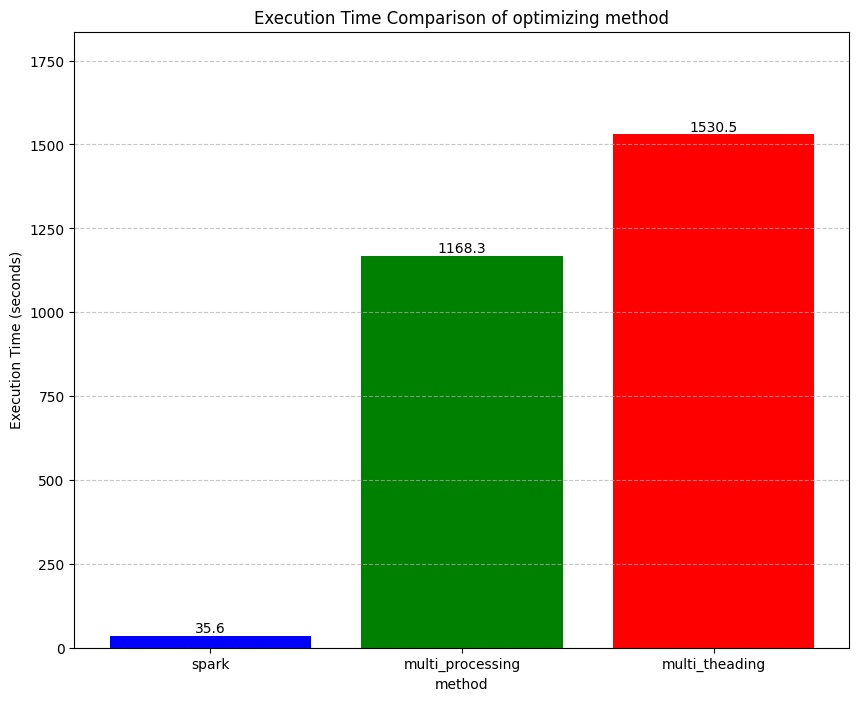

In [ ]:
import matplotlib.pyplot as plt
spark_time=spark_regressor_time.value
method = ['spark', 'multi_processing', 'multi_theading']
execution_times = [spark_time, ml_proc_time, ml_thr_time]

plt.figure(figsize=(10, 8))
bars=plt.bar(method, execution_times, color=['blue', 'green', 'red'])
plt.xlabel('method')
plt.ylabel('Execution Time (seconds)')
plt.title('Execution Time Comparison of optimizing method')
plt.ylim(0, max(execution_times) * 1.2)  # Optional: Adjust y-axis limit for better visualization
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 1), va='bottom', ha='center')
plt.show()
